# Predictive modeling

Let's start with the Crowdflower Airline Sentiment Twitter dataset. 

    A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").
    
This dataset was produced by human categorization. But if you were working for an airline, you can easily imagine that you might want to assess customer sentiment (and reasons for negative sentiment) week by week without manually categorizing thousands of tweets. To do that, you might need to train some kind of predictive model.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from pathlib import Path
import math

### Loading the data

Let's start by loading the data and doing some exploratory analysis.

In [2]:
tweetpath = Path('../../data/tweets/flight_sentiment.tsv')

tweets = pd.read_csv(tweetpath, sep ='\t')

print(tweets.shape)

tweets.head()

(14640, 5)


,airline_sentiment,negativereason,retweet_count,airline,text
0,neutral,NaN,0,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,NaN,0,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,NaN,0,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Bad Flight,0,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Can't Tell,0,Virgin America,@VirginAmerica and it's a really big bad thing...


#### Exploratory data analysis

It's always a good idea to inspect the data before modeling it.

1. Find out what the top three reasons for unhappiness are. 

2. Visualize the distribution of positive, neutral, and negative ```airline_sentiment``` as a bar graph.

3. Examine the full texts of 5 tweets in the "Bad Flight" category, to see what that actually means.

To make full texts a little easier to inspect I'm going to start by telling Pandas to display the full column width.

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
tweets['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

<AxesSubplot:>

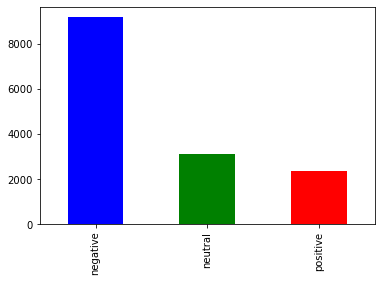

In [17]:
tweets['airline_sentiment'].value_counts().plot.bar(color = ['blue', 'green', 'red'])

In [5]:
tweets.loc[tweets.negativereason == 'Bad Flight', :]

,airline_sentiment,negativereason,retweet_count,airline,text
3,negative,Bad Flight,0,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
17,negative,Bad Flight,0,Virgin America,@VirginAmerica I flew from NYC to SFO last week and couldn't fully sit in my seat due to two large gentleman on either side of me. HELP!
28,negative,Bad Flight,0,Virgin America,@VirginAmerica amazing to me that we can't get any cold air from the vents. #VX358 #noair #worstflightever #roasted #SFOtoBOS
162,negative,Bad Flight,0,Virgin America,@virginamerica why don't any of the pairings include red wine?! Only white is offered :( #redwineisbetter
209,negative,Bad Flight,0,Virgin America,@VirginAmerica seats in Row 8 don't recline should mention that on your website #soreback
...,...,...,...,...,...
14484,negative,Bad Flight,0,American,"@AmericanAir after all, the plane didn’t land in identical or worse) conditions at GRK according to METARs."
14550,negative,Bad Flight,0,American,"@AmericanAir and how is this not a mechanical issue? All evidence points to the idea that it’s the ILS at CLL at fault, not the weather."
14555,negative,Bad Flight,0,American,@AmericanAir fix the engine of flight AA3031so I don't spend all night in your airport so I can fly home tomorrow
14618,negative,Bad Flight,0,American,@AmericanAir 3078 is overweight so you pull 2 dozen passengers off? Why not luggage? Seriously?


### Now create a term-document matrix (wordcounts)

In [6]:
vectorizer = CountVectorizer(max_features = 4000)

I'm going to start occasionally using an alternative way to refer to Pandas columns, which is simply

    ```df.columnname```
    instead of
    ```df['columnname']

This can occasionally be confusing. If you name a column something like "shape" for instance, you could be in trouble! But it's a lot quicker to type.

In [7]:
sparse_wordcounts = vectorizer.fit_transform(tweets.text)
wordcounts = sparse_wordcounts.toarray()
tweetwords = pd.DataFrame(wordcounts, columns = vectorizer.get_feature_names())
tweetwords.head()

,00,000,0016,00pm,02,03,05,05am,05pm,08,...,yr,yrs,yuma,yup,yvr,yyz,zero,zkatcher,zone,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Discussion

If we really cared about maximizing accuracy it would probably be worthwhile to think hard about the strategy we're using to count words. For instance, how will the CountVectorizer handle a hashtag like "#soreback"? How might we ideally want to handle it?

Let's use the technique we learned last time to select some of the words most likely to predict positive or negative sentiment.

In [8]:
negative_words = tweetwords.loc[tweets.airline_sentiment == 'negative', :].sum(axis = 'rows')
positive_words = tweetwords.loc[tweets.airline_sentiment == 'positive', :].sum(axis = 'rows')

In [9]:
def get_dunnings(word, series1, series2):
    observed = pd.DataFrame({'series1': [series1[word], sum(series1) - series1[word]],
                          'series2': [series2[word], sum(series2) - series2[word]]},
                        index = ['word', 'all_others'])
    total_words = observed.to_numpy().sum()
    observed['word_totals'] = observed.sum(axis = 1)
    observed = observed.append(observed.sum(axis = 0).rename(index = 'group_totals'))
    observed.iat[2,2] = 0
    observed['word_totals'] = observed['word_totals'] / sum(observed['word_totals'])
    observed.loc['group_totals', : ] = observed.loc['group_totals', : ] / sum(observed.loc['group_totals', : ])
    expected = np.outer(observed['word_totals'][0:2], observed.loc['group_totals', : ][0:2])
    expected = pd.DataFrame(expected, index = ['word', 'all_others'], columns = ['series1', 'series2'])
    expected = expected * total_words
    
    G = 0
    for i in range(2):
        for j in range(2):
            O = observed.iat[i, j] + .000001
            E = expected.iat[i, j] + .000001
            G = G + O * math.log(O / E)
    
    if (observed.iat[0, 0] / sum(observed.iloc[0: 2, 0])) < (observed.iat[0, 1] / sum(observed.iloc[0 : 2, 1])):
        G = -G    # we provide a signed version of the statistic to distinguish
                  # overrepresentation in the two categories
    
    return 2 * G

In [10]:
dunningslist = []

for w in vectorizer.get_feature_names():
    G = get_dunnings(w, positive_words, negative_words)
    dunningslist.append(G)

dunnings = pd.Series(dunningslist, index = vectorizer.get_feature_names())
dunnings = dunnings.sort_values()

In [11]:
dunnings[0:20]

no          -165.609085
hours       -165.077254
hold        -154.163694
not         -138.953626
cancelled   -130.925833
delayed      -86.071118
flightled    -83.028421
worst        -80.248818
hour         -74.138316
call         -73.718327
why          -65.215920
been         -59.384149
is           -58.140458
hrs          -56.984742
usairways    -55.275240
waiting      -53.808645
can          -48.977909
because      -47.704688
told         -47.414103
luggage      -47.414103
dtype: float64

No one mentions "luggage" or "hours" if they're happy!

In [12]:
dunnings[-20:]

excellent          68.405151
wonderful          68.405151
kudos              79.253573
rock               82.791590
appreciate        103.413990
good              110.310671
http              128.769954
co                145.210322
much              158.874557
virginamerica     171.634044
best              192.788829
amazing           218.934091
you               238.134708
awesome           280.567625
love              287.073472
southwestair      319.243684
jetblue           431.915012
great             553.288110
thanks           1218.129806
thank            1284.022918
dtype: float64

Let's select a list of 400 highly predictive features.

In [13]:
extremefeatures = list(dunnings.index[0:100].values) + list(dunnings.index[-100: ].values)

In [14]:
extremefeatures[0:5]

['no', 'hours', 'hold', 'not', 'cancelled']

### A first model: Naive Bayes

To keep this simple to start with, let's create a dataframe with even numbers of positive and negative tweets. Let's say 200 positive ones and 200 negative ones.

In [18]:
positive_tweets = tweetwords.loc[tweets.airline_sentiment == 'positive', :]
negative_tweets = tweetwords.loc[tweets.airline_sentiment == 'negative', :]

sample400_allwords = pd.concat([positive_tweets.iloc[0:200, : ], negative_tweets.iloc[0: 200, : ]], axis = 'rows')
sample400_allwords.shape

(400, 4000)

Let's also create a version of this data limited to our list of 200 highly predictive (extreme) features.

In [19]:
sample400_ext200 = sample400_allwords.loc[ : , extremefeatures]  # why does this work?
sample400_ext200.shape

(400, 200)

Now we need a list of true labels for the model to predict:

In [20]:
true_sentiment_400 = [1] * 200 + [0] * 200
# what will that produce?

In [21]:
true_sentiment_400[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Now let's train a first model. We'll use just the 200 words that Dunnings identified as extreme.

In [22]:
sm_bayes = MultinomialNB(alpha = .1)   # Alpha sets the "smoothing." Notice we're not using much.
sm_bayes.fit(sample400_ext200, true_sentiment_400)   # Here we actually fit the model

sm_predictions = sm_bayes.predict(sample400_ext200)   # Now let's see what the model predicts if we give it
sum(sm_predictions == true_sentiment_400) / len(sm_predictions)  # the same data.

0.8825

Not a bad prediction. But how would this model do if we gave it new data?

Let's make a bigger dataset, with the next 1500 negative tweets and the next 1500 positive tweets.

In [23]:
next3000 =  pd.concat([positive_tweets.iloc[200: 1700, : ], negative_tweets.iloc[200: 1700, : ]], axis = 'rows')
true_sentiment_3000 = [1] * 1500 + [0] * 1500
next3000.shape

(3000, 4000)

Now a version limited to 200 words that are strongly associated with positive or negative tweets.

In [24]:
next3000_ext200 = next3000.loc[ : , extremefeatures]
next3000_ext200.shape

(3000, 200)

In [25]:
sm_predictions = sm_bayes.predict(next3000_ext200)
sum(sm_predictions == true_sentiment_3000) / len(sm_predictions)

0.7953333333333333

Oh, that's much worse. Maybe we could improve this by increasing the number of words we use to predict? Let's train on the version of our 400-tweet dataset that has all 5000 words.

In [26]:
big_bayes = MultinomialNB(alpha = 0.1)
big_bayes.fit(sample400_allwords, true_sentiment_400)
big_predictions = big_bayes.predict(sample400_allwords)
sum(big_predictions == true_sentiment_400) / len(big_predictions)

0.9925

Ah, yes. Including lots more words makes our model almost perfectly accurate on the 400 tweets we used to train it.

Maybe that will also improve accuracy on the new data?

In [27]:
big_predictions = big_bayes.predict(next3000.loc[ : , : ])
sum(big_predictions == true_sentiment_3000) / len(big_predictions)

0.7313333333333333

Yikes!! This is not helping.

#### Discussion:

What do we need to do to improve accuracy?

#### Exercise:

Working in small groups, construct a loop that implements the solution we've described, and finds the parameter setting that maximizes accuracy *on our large 3000-tweet dataset.*

In [28]:
for alpha in [.01, .1, 1, 2, 4, 6, 10]:
    big_bayes = MultinomialNB(alpha = alpha)
    big_bayes.fit(sample400_allwords, true_sentiment_400)
    big_predictions = big_bayes.predict(next3000.loc[ : , : ])
    print(alpha, sum(big_predictions == true_sentiment_3000) / len(big_predictions))
    

0.01 0.6926666666666667
0.1 0.7313333333333333
1 0.759
2 0.7573333333333333
4 0.7503333333333333
6 0.7376666666666667
10 0.7216666666666667


#### Note:

Separating test and train datasets is a strategy to avoid overfitting, and the exercise above was designed to demonstrate why overfitting is a danger.

But there are several aspects of what we did above that aren't actually recommended practice.

1. First, we had a small training dataset (400) and a big test set (3000). But you normally have a training dataset that is much larger than the test dataset. Ratios of 7 to 3 or 9 to 1 are common.

2. It's not a good idea to do *feature selection* on the whole dataset. We selected our "extreme 400" features by calculating Dunning's log-likelihood on the whole corpus of tweets--but really, if we wanted to use a feature selection strategy, we should only calculate Dunning's on the *training* dataset. Otherwise we may get misleadingly high accuracy. Can you figure out why?

### Inspect probabilities

In [29]:
sm_probabilities = sm_bayes.predict_proba(sample400_ext200)
sm_predictions = sm_bayes.predict(sample400_ext200)
sm_probabilities[0:10]

array([[0.24716759, 0.75283241],
       [0.66905453, 0.33094547],
       [0.49552751, 0.50447249],
       [0.08209022, 0.91790978],
       [0.1042556 , 0.8957444 ],
       [0.48221875, 0.51778125],
       [0.01739582, 0.98260418],
       [0.05254278, 0.94745722],
       [0.24080718, 0.75919282],
       [0.32471968, 0.67528032]])

In [30]:
sm_probabilities = [x[1] for x in sm_probabilities]
sm_probabilities[0:10]

[0.7528324064379827,
 0.3309454659730444,
 0.5044724868392012,
 0.9179097801485073,
 0.8957443989764363,
 0.5177812508721986,
 0.9826041794136698,
 0.9474572248679309,
 0.7591928179406537,
 0.6752803203150606]

In [31]:
sm_predictions[0:10]

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

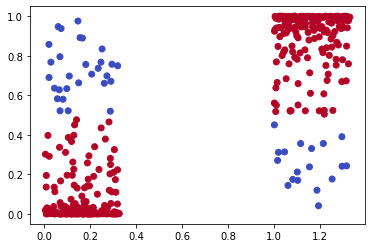

In [32]:
plt.scatter(np.array(true_sentiment_400) + np.random.random(size = 400)/3, np.array(sm_probabilities),
            c = (sm_predictions == np.array(true_sentiment_400)), cmap = 'coolwarm')

## Logistic regression, and how we might really do this

Naive Bayes is simple, which makes it a good example to teach first. But in real-life problems (especially if documents are reasonably long), regularized logistic regression is more commonly where a modeling process will start. There are lots of approaches more sophisticated than logistic regression, but LR makes a good "baseline," and is often in practice good enough for the task.

As we work through a solution here, I'm going to dispense with some of the simplifying assumptions we initially made. For instance, we constructed an imaginary world where classes of tweets were "balanced" (of equal size). As we know, that's not actually true in our real-world data. 

So let's go back to our original complete doc-term matrix, ```tweetwords```.

#### preparing the data

Because this matrix is based on raw word counts, it conflates word frequency with tweet length. Tweet-length might be an interesting predictive feature, but we probably don't want it mixed into all the different words. Let's factor it out.


In [33]:
tweetlengths = tweets['text'].str.len()
tweetlengths[0:10]

0     35
1     72
2     71
3    126
4     55
5    135
6     79
7    108
8     47
9     80
Name: text, dtype: int64

In [34]:
wordfreqs = tweetwords.divide(tweetlengths, axis = 'rows')
wordfreqs['#tweetlen'] = tweetlengths
wordfreqs

,00,000,0016,00pm,02,03,05,05am,05pm,08,...,yrs,yuma,yup,yvr,yyz,zero,zkatcher,zone,zurich,#tweetlen
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,126
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63
14636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150
14637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60
14638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135


We're going to want to hold out a "test" set to finally confirm the quality of our model. This should be randomly selected from all tweets, and we don't know the current sequence is random. So let's shuffle.

In [35]:
wordfreqs = wordfreqs.sample(frac = 1)
wordfreqs.head()

,00,000,0016,00pm,02,03,05,05am,05pm,08,...,yrs,yuma,yup,yvr,yyz,zero,zkatcher,zone,zurich,#tweetlen
13296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140
778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144
7023,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60
10182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75
10979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,105


Notice that the indexes were shuffled too. This allows us to create a reordered ```tweets``` frame in the same order. We're going to need this if we want to know the true sentiment for all those rows.

In [36]:
reorderedtweets = tweets.loc[wordfreqs.index, : ]
reorderedtweets.head()

,airline_sentiment,negativereason,retweet_count,airline,text
13296,negative,Flight Attendant Complaints,0,American,@AmericanAir @cnnbrk she tried they are not doing anything said they would talk to stewardess about serving drunks drinks how does that help
778,negative,Can't Tell,0,United,@united I'm constantly having challenges with upgrades &amp; charges. In order to prevent DVT I have to pay an addtl $180 http://t.co/xC6jQ70r7B
7023,neutral,NaN,0,Delta,😂😂 RT @JetBlue: Our fleet's on fleek. http://t.co/rinzYSK6kI
10182,negative,Cancelled Flight,0,US Airways,@USAirways Good grief! Flight Cancelled Flightled. Been on hold since 0400.
10979,negative,Late Flight,0,US Airways,@USAirways I have been on three planes for flight 1907 and still haven't left the ground BAD SERVICE #sad


For our simplifying purposes let's get rid of 'neutral's.

In [37]:
wordfreqs = wordfreqs.loc[reorderedtweets['airline_sentiment'] != 'neutral', : ]
reorderedtweets = reorderedtweets.loc[reorderedtweets['airline_sentiment'] != 'neutral', : ]
wordfreqs.shape

(11541, 4001)

Now let's separate the tweets into test and train sets. There's not a hard and fast rule on proportions here; it depends on how much data you have. People with tons of data may do a 90-10 split. 11,541 rows is not exactly tons and we want a good readout of final accuracy, so let's set 2000 aside.

In [38]:
testfreqs = wordfreqs.iloc[0: 2000, : ]
test_y = (reorderedtweets['airline_sentiment'][0: 2000] == 'positive').astype(int)  # try taking the last part out
test_y[0:10]

13296    0
778      0
10182    0
10979    0
3356     0
1086     1
7906     0
11056    0
9489     0
10107    0
Name: airline_sentiment, dtype: int64

In [39]:
trainfreqs = wordfreqs.iloc[2000 : , : ]
train_y = (reorderedtweets['airline_sentiment'][2000: ] == 'positive').astype(int) 
train_y[0:10]

12704    1
4144     0
11729    0
12121    0
11676    1
2852     0
660      0
7680     0
6980     0
9747     0
Name: airline_sentiment, dtype: int64

We want regularization to spread evenly across different variables, even though some variables (like ```#tweetlen```) are numerically much bigger than others. So we typically "scale" our X matrices before using logistic regression.

In [40]:
trainscaler = StandardScaler()
trainXscaled = trainscaler.fit_transform(trainfreqs)
trainXscaled = pd.DataFrame(trainXscaled, columns = trainfreqs.columns)
trainXscaled.head()

,00,000,0016,00pm,02,03,05,05am,05pm,08,...,yrs,yuma,yup,yvr,yyz,zero,zkatcher,zone,zurich,#tweetlen
0,-0.030217,-0.048307,-0.010238,-0.014474,-0.01909,-0.014391,-0.024479,-0.010238,-0.017497,-0.016838,...,-0.023857,-0.019246,-0.024403,-0.017481,-0.031032,-0.056441,-0.017555,-0.020057,-0.017619,-1.448856
1,-0.030217,-0.048307,-0.010238,-0.014474,-0.01909,-0.014391,-0.024479,-0.010238,-0.017497,-0.016838,...,-0.023857,-0.019246,-0.024403,-0.017481,-0.031032,-0.056441,-0.017555,-0.020057,-0.017619,-0.263589
2,-0.030217,-0.048307,-0.010238,-0.014474,-0.01909,-0.014391,-0.024479,-0.010238,-0.017497,-0.016838,...,-0.023857,-0.019246,-0.024403,-0.017481,-0.031032,-0.056441,-0.017555,-0.020057,-0.017619,0.921678
3,-0.030217,-0.048307,-0.010238,-0.014474,-0.01909,-0.014391,-0.024479,-0.010238,-0.017497,-0.016838,...,-0.023857,-0.019246,-0.024403,-0.017481,-0.031032,-0.056441,-0.017555,-0.020057,-0.017619,0.690406
4,-0.030217,-0.048307,-0.010238,-0.014474,-0.01909,-0.014391,-0.024479,-0.010238,-0.017497,-0.016838,...,-0.023857,-0.019246,-0.024403,-0.017481,-0.031032,-0.056441,-0.017555,-0.020057,-0.017619,-2.634123


In [42]:
testscaler = StandardScaler()
testXscaled = testscaler.fit_transform(testfreqs)
testXscaled = pd.DataFrame(testXscaled, columns = testfreqs.columns)

**Discussion**: why are we scaling these two matrices separately? Why not scale the whole thing together before dividing into test and train sets?

**Answer:** That could leak information from the test set into the training set, and would reduce our confidence that we're really "learning" — that is, training a model that will generalize to new, unseen data.

#### cross-validating a model

If we just wanted to train and test a single model--and if we only wanted to measure "accuracy"--this would be simple.

In [43]:
logist = LogisticRegression(C = .1, max_iter = 1000) 
logist.fit(trainXscaled, train_y)

predictions = logist.predict(testXscaled)
sum(predictions == test_y) / len(predictions)

0.903

Why is this not a very safe measurement? Well, how many positive tweets do we actually have in our test set?

In [44]:
sum(test_y) / len(test_y)

0.1965

So you can get 80% "accuracy" just by predicting "negative" in every case.

A better measurement is F1 score:

    F1 = 2 * (precision * recall) / (precision + recall)

The simple way to calculate this is

In [45]:
f1_score(test_y, predictions)

0.75

but that doesn't help us understand the number, so ...

#### EXERCISE 3:

working in small groups, calculate precision: the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 

then recall: the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 

Then calculate your f1 score, which should equal what *you* got above. Note that since we randomized the test/train split, everyone's result will be slightly different.

In [47]:
tp = sum((test_y == 1) & (predictions == 1))
fp = sum((test_y == 0) & (predictions == 1))
fn = sum((test_y == 1) & (predictions == 0))

precision = tp / (tp + fp)
recall = tp / (tp + fn)

F1 = 2 * (precision * recall) / (precision + recall)

print(round(precision, 4), round(recall, 4), round(F1, 4))


0.7598 0.7405 0.75


So this model has higher precision than recall; it's failing to recognize some positive tweets.

### handling imbalanced classes

To keep your model from always choosing "negative," you can weight the classes inversely to their frequency. This will make errors in rare classes more costly.

In [48]:
logist = LogisticRegression(C = .1, max_iter = 1000, class_weight = 'balanced') 
logist.fit(trainXscaled, train_y)

predictions = logist.predict(testXscaled)

tp = sum((test_y == 1) & (predictions == 1))
fp = sum((test_y == 0) & (predictions == 1))
fn = sum((test_y == 1) & (predictions == 0))

precision = tp / (tp + fp)
recall = tp / (tp + fn)

F1 = 2 * (precision * recall) / (precision + recall)

print(round(precision, 4), round(recall, 4), round(F1, 4))

0.7095 0.7583 0.7331


**Note:** This strategy is not guaranteed to improve the overall F1 score in every case. But it probably is significant that it has changed the balance between prevision and recall.

The C parameter sets smoothing. It's like alpha in Naive Bayes, except size is reversed here: low numbers equal stronger smoothing. We could fiddle around with C until we got a good number on our test set, but then we might be overfitting our test set. 

**Discussion:** Why?

**Answer:** Again, the problem is that we're leaking some information about the test set into the training process.

An alternative is to fiddle around with the *training* set until we get a good C parameter, and then test that number on the test set (being careful not to look at it until the final stage.)

But we don't want to overfit the training set in the process of "fiddling around" on it. Otherwise we'll tend to choose less regularization than we really need for the test set.

A solution here is to "cross-validate" on the training set: repeatedly divide it, train on say 4/5th of the data, and test on the remaining fifth.


In [49]:
logist = LogisticRegression(C = .01, max_iter = 1000, class_weight = 'balanced')
results = cross_validate(logist, trainXscaled, train_y, cv = 5, scoring = 'f1')
print(results)
print()
print('Mean f1:', np.mean(results['test_score']))

{'fit_time': array([1.19712424, 1.04555511, 1.1467638 , 1.0185957 , 1.05130696]), 'score_time': array([0.03987408, 0.03930521, 0.04278016, 0.03945923, 0.04961991]), 'test_score': array([0.74939173, 0.76695438, 0.74905422, 0.73737374, 0.72862454])}

Mean f1: 0.7462797203919321


Technically, to be extremely cautious, we would "scale" each fold of the cross-validation separately. This can be done in sklearn using a "pipeline," but it adds more complexity than we need for this exercise and doesn't actually change our result greatly.

#### EXERCISE 4:

Construct a for-loop that tests C parameters ranging from .00001 to 10, varying by powers of 10.

    [.00001, .0001, .001, .01, .1, 1, 10]

In each case, cross-validate on trainXscaled and report the f1 score. When you've got the C parameter that works best, use that model to make a prediction on testXscaled, and calculate both f1 score and accuracy for that prediction.

In [51]:
for c_param in [.00001, .0001, .001, .01, .1, 1, 10]:
    logist = LogisticRegression(C = c_param, max_iter = 1000, class_weight = 'balanced') 
    results = cross_validate(logist, trainXscaled, train_y, cv = 5, scoring = 'f1')
    print('C parameter:', c_param)
    print('Mean f1:', np.mean(results['test_score']))
    print()

C parameter: 1e-05
Mean f1: 0.7613891748318042

C parameter: 0.0001
Mean f1: 0.7631374641196054

C parameter: 0.001
Mean f1: 0.7660025210823667

C parameter: 0.01
Mean f1: 0.7462797203919321

C parameter: 0.1
Mean f1: 0.7297491179145769

C parameter: 1
Mean f1: 0.7190563121310635

C parameter: 10
Mean f1: 0.7102743065446762



So the best C parameter is .001. Now we train a model using that parameter on the whole training set, and see how it performs on the test set.

In [53]:
logist = LogisticRegression(C = .001, max_iter = 1000, class_weight = 'balanced') 
logist.fit(trainXscaled, train_y)
predictions = logist.predict(testXscaled)

tp = sum((test_y == 1) & (predictions == 1))
fp = sum((test_y == 0) & (predictions == 1))
fn = sum((test_y == 1) & (predictions == 0))

precision = tp / (tp + fp)
recall = tp / (tp + fn)

F1 = 2 * (precision * recall) / (precision + recall)

print(round(precision, 4), round(recall, 4), round(F1, 4))

0.7433 0.7812 0.7618


So F1 measure of .76 is a pretty reliable picture of how well we can separate negative and positive tweets in the future.

What if we wanted to interpret this model. Can we extract coefficients?

#### identify predictive features



In [54]:
logist = LogisticRegression(C = c_param, max_iter = 1000, class_weight = 'balanced')
logist.fit(trainXscaled, train_y)
coefficients = [x for x in zip(logist.coef_[0], vectorizer.get_feature_names())]

In [55]:
coefficients.sort()

In [56]:
coefficients[0:20]

[(-1.7117043847030566, 'not'),
 (-1.6374540241894129, 'worst'),
 (-1.6030467892361757, 'hour'),
 (-1.5062158807277217, 'no'),
 (-1.3533575522349082, 'money'),
 (-1.3183799823422273, 'delayed'),
 (-1.3056010947190504, 'bit'),
 (-1.0414080410457107, 'united'),
 (-1.0390196286999462, 'luggage'),
 (-1.0200034060112166, 'hours'),
 (-0.9900319942873045, 'still'),
 (-0.9632916046159501, 'let'),
 (-0.9405220835404323, 'my'),
 (-0.9364040186855526, 'sucks'),
 (-0.9216294465734982, 'nothing'),
 (-0.8914680730617341, 'late'),
 (-0.8900772316836659, 'rude'),
 (-0.8853571986426362, 'hung'),
 (-0.8836141851534709, 'nightmare'),
 (-0.8573631183855567, 'americanair')]

In [57]:
coefficients[-20:]

[(0.7500774026605328, 'best'),
 (0.7515610516150587, 'proud'),
 (0.7648435190320645, 'excellent'),
 (0.8040732038508063, 'jetblue'),
 (0.8085866899794636, 'kudos'),
 (0.8130281273154139, 'fun'),
 (0.8174107124468666, 'made'),
 (0.8436733372559074, 'beautiful'),
 (0.8623768551350586, 'loved'),
 (0.9333926630585165, 'good'),
 (0.9735490801026193, 'pleasure'),
 (1.0044545676833794, 'thx'),
 (1.0597639949059505, 'amazing'),
 (1.1932485618769935, 'new'),
 (1.313671612167603, 'appreciate'),
 (1.6727148661375617, 'awesome'),
 (2.0363509781665843, 'love'),
 (2.3797411248727927, 'great'),
 (3.9116302897781026, 'thank'),
 (4.576125945294653, 'thanks')]

We can definitely extract coefficients for features. But note that these coefficients are not necessarily easy to interpret. The thing that makes logistic regression stronger than naive Bayes, you'll recall, is that there are no independence assumptions on variables. But this also means that different variables can interact with each other in unpredictable ways. The term you'll hear used for this is "multicollinearity." 